# Building Data Engineering Pipelines in Python

## Ingesting Data

### Introduction to data ingestion with singer

singer is a common data format, Singers describing the data throught ist schemas

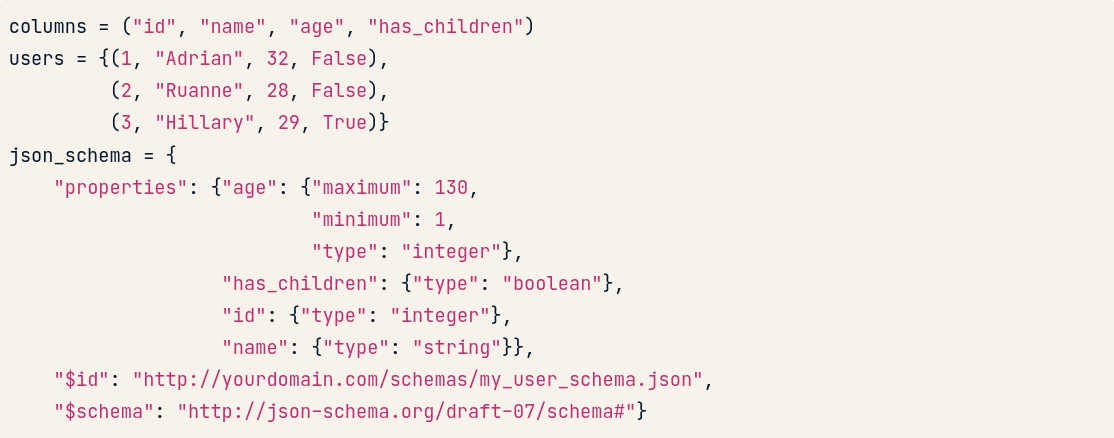

Because JSON is ubiquitous, you should be able to read and write this format. As you will see in the next lesson, many configuration files in Singer hold JSON.

In this exercise, you will write some configuration details of a database to a JSON file. Doing this is good practice by the way, as it keeps hardcoded parts out of your code, which allows other people to reference the same configuration files using other languages even.

In [1]:
# Import json
import json
import singer
database_address = {
  "host": "10.0.0.5",
  "port": 8456
}

# Open the configuration file in writable mode
with open("database_config.json", "w") as fh:
  # Serialize the object in this file handle
  json.dump(obj=database_address, fp=fh) 

In [2]:
# Complete the JSON schema
schema = {'properties': {
    'brand': {'type': 'string'},
    'model': {'type': 'string'},
    'price': {'type': 'number'},
    'currency': {'type': 'string'},
    'quantity': {'type': 'number', 'minimum': 1},  
    'date': {'type': 'string', 'format': 'date'},
    'countrycode': {'type': 'string', 'pattern': "^[A-Z]{2}$"}, 
    'store_name': {'type': 'string'}}}

# Write the schema
singer.write_schema(stream_name="products", schema=schema, key_properties=[])

{"type": "SCHEMA", "stream": "products", "schema": {"properties": {"brand": {"type": "string"}, "model": {"type": "string"}, "price": {"type": "number"}, "currency": {"type": "string"}, "quantity": {"type": "number", "minimum": 1}, "date": {"type": "string", "format": "date"}, "countrycode": {"type": "string", "pattern": "^[A-Z]{2}$"}, "store_name": {"type": "string"}}}, "key_properties": []}


## Creating a data transformation pipeline with PySpark

In [3]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession


# Create my_spark
spark = SparkSession.builder.getOrCreate()


23/10/10 09:45:19 WARN Utils: Your hostname, sergio-Lenovo-Y520-15IKBN resolves to a loopback address: 127.0.1.1; using 192.168.1.17 instead (on interface wlp3s0)
23/10/10 09:45:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/10 09:45:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Read a csv file and set the headers
df = (spark.read
      .options(header=True)
      .csv("data/ratings.csv"))

df.show()

+------------+-------+---------------+-------+
|       brand|  model|absorption_rate|comfort|
+------------+-------+---------------+-------+
|Diapers-R-Us|6months|              2|      3|
|     Nappy-k|2months|              3|      4|
|     Pampers|3months|              4|      4|
|     Huggies|newborn|              3|      5|
+------------+-------+---------------+-------+



we can define de schema data

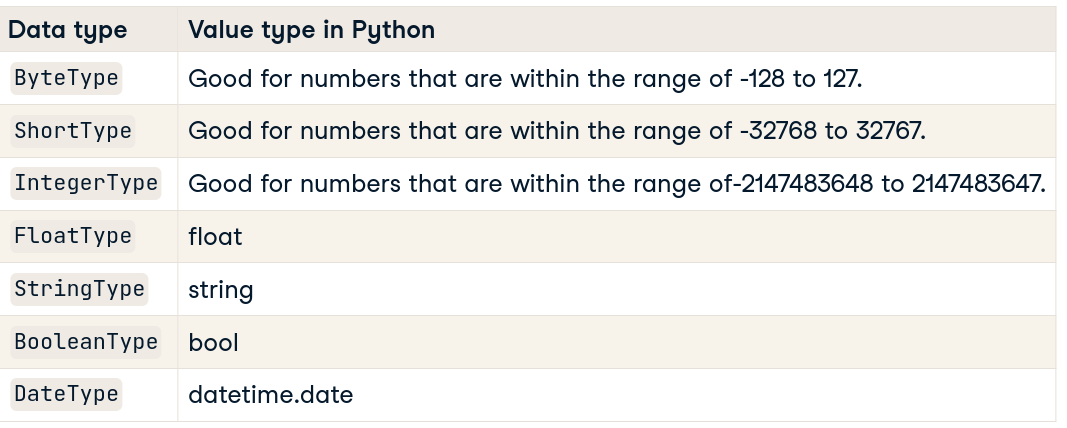

In [5]:
from pyspark.sql.types import StructType,StructField,StringType,IntegerType,ByteType
import pprint

# Define the schema
schema = StructType([
  StructField("brand", StringType(), nullable=False),
  StructField("model", StringType(), nullable=False),
  StructField("absorption_rate", IntegerType(), nullable=True),
  StructField("comfort", IntegerType(), nullable=True)
])

better_df = (spark
             .read
             .options(header="true")
             # Pass the predefined schema to the Reader
             .schema(schema)
             .csv("data/ratings.csv"))
pprint.pprint(better_df.dtypes)

[('brand', 'string'),
 ('model', 'string'),
 ('absorption_rate', 'int'),
 ('comfort', 'int')]


### Cleaning Data

to delete null values from our data we can use the DROPMALFORMED mode

In [6]:
# Specify the option to drop invalid rows
ratings = (spark
           .read
           .options(header=True, mode="DROPMALFORMED")
           .csv("data/ratings_with_invalid_rows.csv"))
ratings.show()

+------------+-------+---------------+-------+
|       brand|  model|absorption_rate|comfort|
+------------+-------+---------------+-------+
|Diapers-R-Us|6months|              2|      3|
|     Nappy-k|2months|              3|      4|
|     Pampers|3months|              4|      4|
|     Huggies|newborn|              3|      5|
+------------+-------+---------------+-------+



we can fill missing values and create a condition to fill data

In [7]:
print("BEFORE")
ratings = (spark
           .read
           .options(header=True).schema(schema)
           .csv("data/ratings_with_invalid_rows.csv"))
ratings.show()


print("AFTER")
# Replace nulls with arbitrary value on column subset
ratings = ratings.fillna(4, subset=["comfort"])
ratings.show()

BEFORE
+------------+-------+---------------+-------+
|       brand|  model|absorption_rate|comfort|
+------------+-------+---------------+-------+
|Diapers-R-Us|6months|              2|      3|
|     Nappy-k|2months|              3|      4|
|     Pampers|3months|              4|      4|
|     Huggies|newborn|              3|      5|
|     Pampers|    2mo|           NULL|   NULL|
+------------+-------+---------------+-------+

AFTER
+------------+-------+---------------+-------+
|       brand|  model|absorption_rate|comfort|
+------------+-------+---------------+-------+
|Diapers-R-Us|6months|              2|      3|
|     Nappy-k|2months|              3|      4|
|     Pampers|3months|              4|      4|
|     Huggies|newborn|              3|      5|
|     Pampers|    2mo|           NULL|      4|
+------------+-------+---------------+-------+



In [8]:
from pyspark.sql.functions import col, when

# Add/relabel the column
categorized_ratings = ratings.withColumn(
    "comfort",
    # Express the condition in terms of column operations
    when(col("comfort") > 3, "sufficient").otherwise("insufficient"))

categorized_ratings.show()

+------------+-------+---------------+------------+
|       brand|  model|absorption_rate|     comfort|
+------------+-------+---------------+------------+
|Diapers-R-Us|6months|              2|insufficient|
|     Nappy-k|2months|              3|  sufficient|
|     Pampers|3months|              4|  sufficient|
|     Huggies|newborn|              3|  sufficient|
|     Pampers|    2mo|           NULL|  sufficient|
+------------+-------+---------------+------------+



### Transforming data with Spark

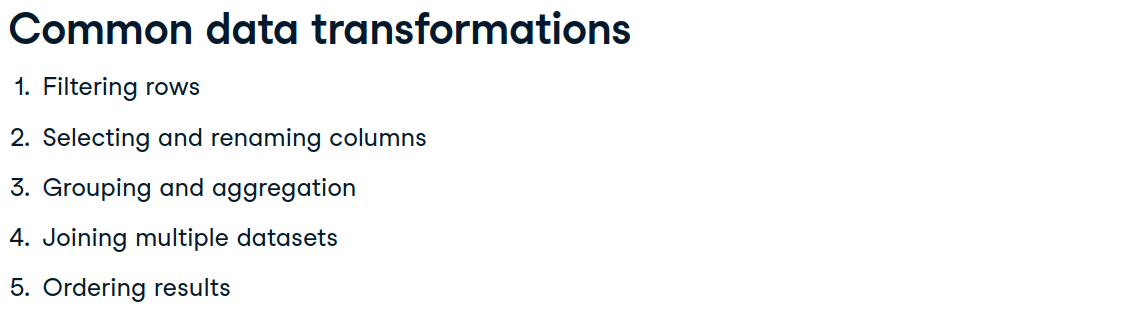

we can filter and ordering rows

we cans select and renaming columns

In [9]:

# Select the columns and rename the "absorption_rate" column
result = ratings.select([col("brand"),
                       col("model"),
                       col("absorption_rate").alias("absorbency")])

# Show only unique values
result.distinct().show()

+------------+-------+----------+
|       brand|  model|absorbency|
+------------+-------+----------+
|Diapers-R-Us|6months|         2|
|     Nappy-k|2months|         3|
|     Huggies|newborn|         3|
|     Pampers|3months|         4|
|     Pampers|    2mo|      NULL|
+------------+-------+----------+



we can grouping and aggregate

In [10]:
from pyspark.sql.functions import col, avg, stddev_samp, max as sfmax
schema = StructType([
  StructField("Country", StringType(), nullable=False),
  StructField("Age", ByteType(), nullable=False),
  StructField("Salary", IntegerType(), nullable=True),
  StructField("Purchased", StringType(), nullable=True)
])

purchased=spark.read.options(header=True).schema(schema).csv("data/purchased.csv")

aggregated = (purchased
              # Group rows by 'Country'
              .groupBy(col('Country'))
              .agg(
                # Calculate the average salary per group and rename
                avg('Salary').alias('average_salary'),
                # Calculate the standard deviation per group
                stddev_samp('Salary'),
                # Retain the highest salary per group and rename
                sfmax('Salary').alias('highest_salary')
              )
             )

aggregated.show()

+-------+--------------+-------------------+--------------+
|Country|average_salary|stddev_samp(Salary)|highest_salary|
+-------+--------------+-------------------+--------------+
|Germany|       63000.0|               NULL|         63000|
| France|       48000.0|               NULL|         48000|
|  Spain|       62000.0| 12727.922061357855|         71000|
+-------+--------------+-------------------+--------------+



### Packaging your application

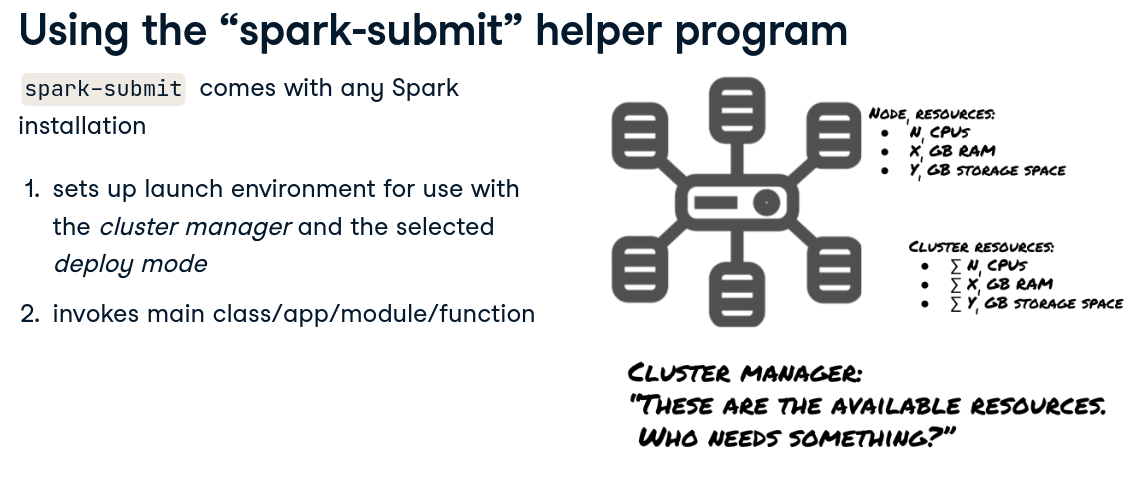

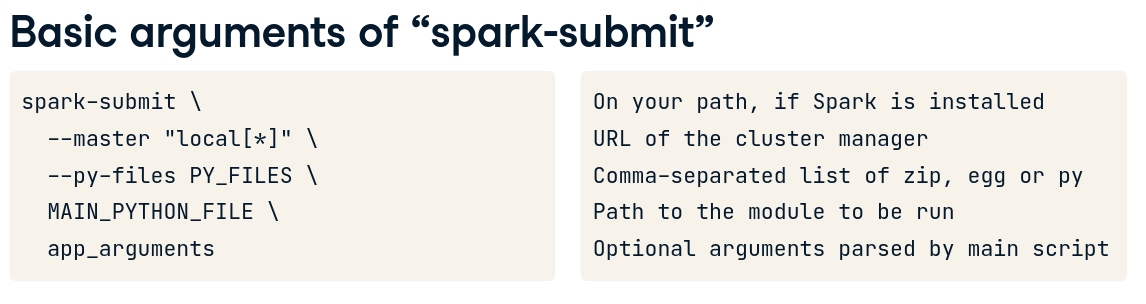

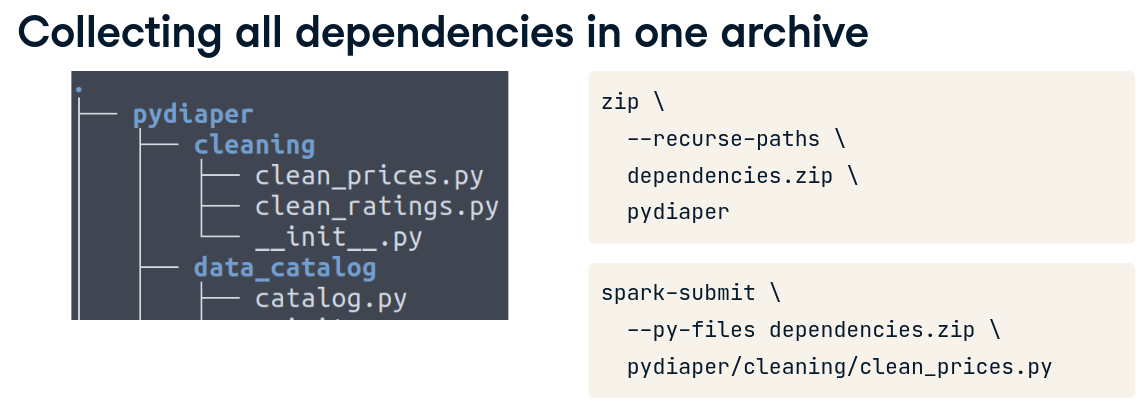

###  Testing your data pipeline

we can create a unit test like pytest in spark

firs we create a example dataFrame

In [11]:
from datetime import date
from pyspark.sql import Row

Record = Row("country", "utm_campaign", "airtime_in_minutes", "start_date", "end_date")

# Create a tuple of records
data = (
  Record("USA", "DiapersFirst", 28, date(2017, 1, 20), date(2017, 1, 27)),
  Record("Germany", "WindelKind", 31, date(2017, 1, 25), None),
  Record("India", "CloseToCloth", 32, date(2017, 1, 25), date(2017, 2, 2))
)

# Create a DataFrame from these records
frame = spark.createDataFrame(data)
frame.show()

+-------+------------+------------------+----------+----------+
|country|utm_campaign|airtime_in_minutes|start_date|  end_date|
+-------+------------+------------------+----------+----------+
|    USA|DiapersFirst|                28|2017-01-20|2017-01-27|
|Germany|  WindelKind|                31|2017-01-25|      NULL|
|  India|CloseToCloth|                32|2017-01-25|2017-02-02|
+-------+------------+------------------+----------+----------+



the example is in the examples folder, in this case we can test the outputs schema in a function


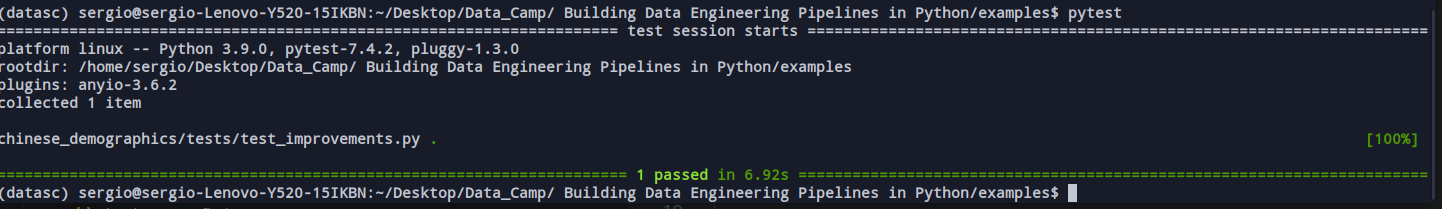

## Managing and orchestrating a workflow

Modern day workflow management

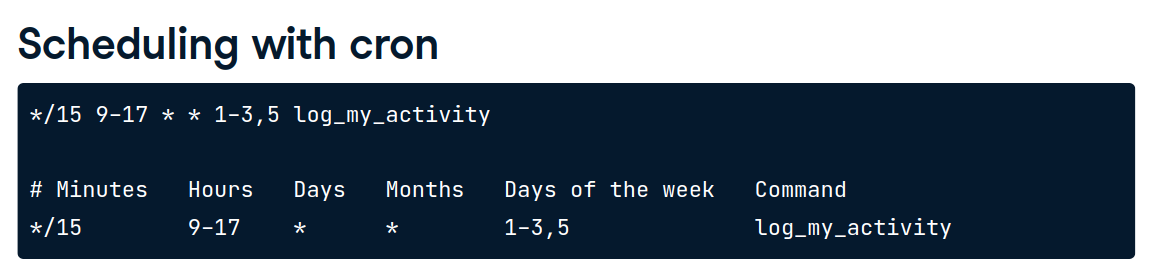

now we will make workflow wiyh airflow

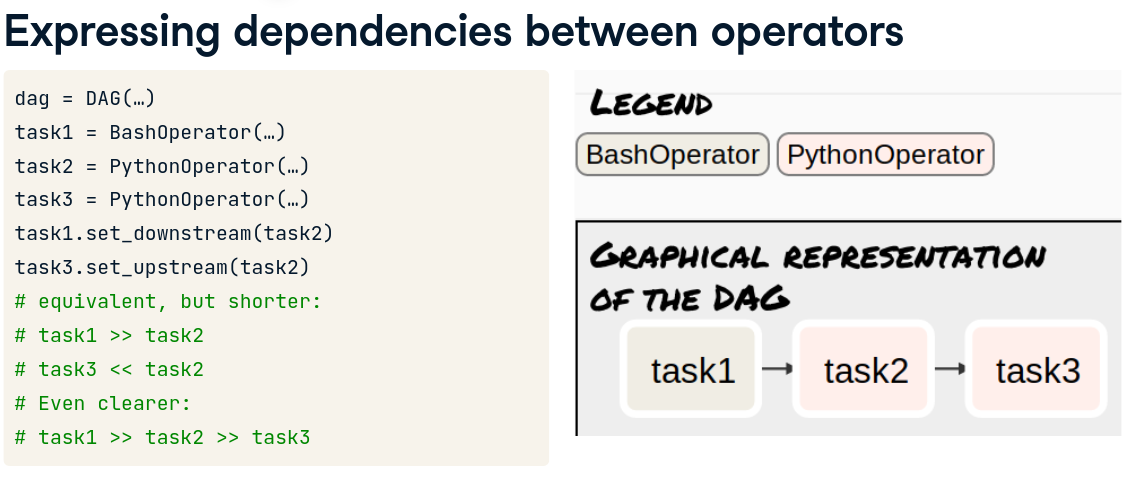

In [17]:
from datetime import datetime
from airflow import DAG

[2023-10-10T10:55:42.759-0500] {logging_config.py:71} ERROR - Unable to load the config, contains a configuration error.


ValueError: Unable to configure formatter 'airflow'